In [52]:
import os, csv, cv2, sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.utils import shuffle
import scipy.ndimage
import matplotlib.pyplot as plt

# Aggregating and renaming samples
data_list = ['./data/']
samples = []
for source in data_list:
    with open(source+'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            line[0], line[1] = line[1], line[0] # Correcting the order of left/center to be more logical
            for i in range(3):
                line[i] = source+'IMG/'+line[i].split('/')[-1] # Rewriting image paths
            samples.append(line)

# Data split
train_samples, validation_samples = train_test_split(samples[1:], test_size=0.2) # excluding the header line

# Helper functions for image processing

# Random flipping
def random_flip(image, angle, prob):
    if (np.random.uniform()<prob):
        image = cv2.flip(image,1)
        angle = angle*-1.0
    return image, angle

# Random brightness
def random_brightness(image, angle, factor_min, factor_max):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * np.random.uniform(factor_min, factor_max)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return image, angle

# Random shear, adapted from https://github.com/ksakmann/CarND-BehavioralCloning/blob/master/model.py
def random_shear(image,angle,range):
    rows,cols,ch = image.shape
    dx = range*np.random.randn() # Modifed for normal sampling to reduce oscillations
    p1 = np.float32([[0,rows],[cols,rows],[cols/2,rows/2]])
    p2 = np.float32([[0,rows],[cols,rows],[cols/2+dx,rows/2]])
    M = cv2.getAffineTransform(p1,p2) # Transforming middle point while maintaining bottom same
    image = cv2.warpAffine(image,M,(cols,rows),borderMode=1)
    dangle = dx/(rows/2) * 360/(2*np.pi*25.0) / 6.0
    angle += dangle
    return image, angle

# Random lateral shift
def random_shift(image,angle,range):
    s = np.random.uniform(-range, range+1)
    image = scipy.ndimage.interpolation.shift(image,[0,s,0])
    angle += 0.003*s
    return image, angle

# Random preprocessing
def random_modif(image, angle):
    # Random flipping
    image, angle = random_flip(image, angle, 0.5)
    # Random brightness
    image, angle = random_brightness(image, angle, 0.5, 1.2)
    # Random shear
    image, angle = random_shear(image, angle, 50)
    # Smoothing for position in the lane
    image, angle = random_shift(image, angle, 50)
    # Angle smoothing
    # angle = angle*(1+0.04*np.random.uniform(-1, 1))
    return image, angle

# Image generator
def generator_new(samples, batch_size=32):
    
    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        n_batch = 0
        images, angles = [], []

        while n_batch < batch_size:

            sample = samples[n_batch]
            
            # Random selection between left/center/right image
            n = np.random.choice([0,1,2])
            image = cv2.imread(sample[n])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Correct inversion of colors by cv2.imread
            angle = float(sample[3])+0.2*(1-n) # Correcting angle
            
            # Random data preprocessing
            image, angle = random_modif(image, angle)
            images.append(image)
            angles.append(angle)
            n_batch +=1

        X_train = np.array(images)
        y_train = np.array(angles)
        yield shuffle(X_train, y_train)

# Generator by sample
train_generator = generator_new(train_samples, batch_size=256)
validation_generator = generator_new(validation_samples, batch_size=256)

In [53]:
samples = samples[1:]

In [54]:
len(samples)

8036

In [55]:
samples = shuffle(samples)

In [60]:
steer = []
for i in range(len(samples)):
    for j in range(3):
        angle = float(samples[i][3])+0.2*(1-j)
        steer += [angle]

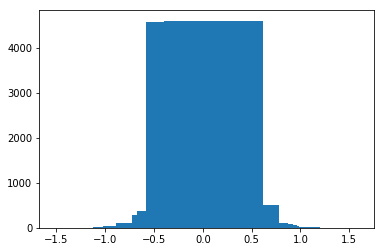

In [61]:
hist = np.histogram(steer, bins = 100)
figsize=(15,15)
plt.bar(hist[1][1:],hist[0])
plt.show()

In [79]:
image = cv2.imread(samples[0][n])
new_steer = []
for i in range(len(samples)):
    for j in range(3):
        angle = float(samples[i][3])+0.2*(1-j)
        image, angle = random_modif(image, angle)
        new_steer += [angle]

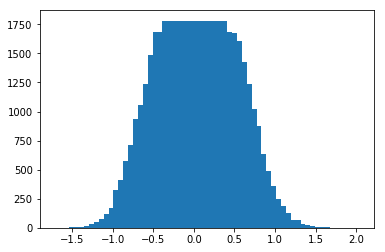

In [81]:
hist = np.histogram(new_steer, bins = 50)
figsize=(15,15)
plt.bar(hist[1][1:],hist[0])
plt.show()

In [67]:
sample = shuffle(train_samples)[0]
n = 1
image = cv2.imread(sample[n])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Correct inversion of colors by cv2.imread
angle = float(sample[3])+0.2*(1-n)
print(angle)

0.100034


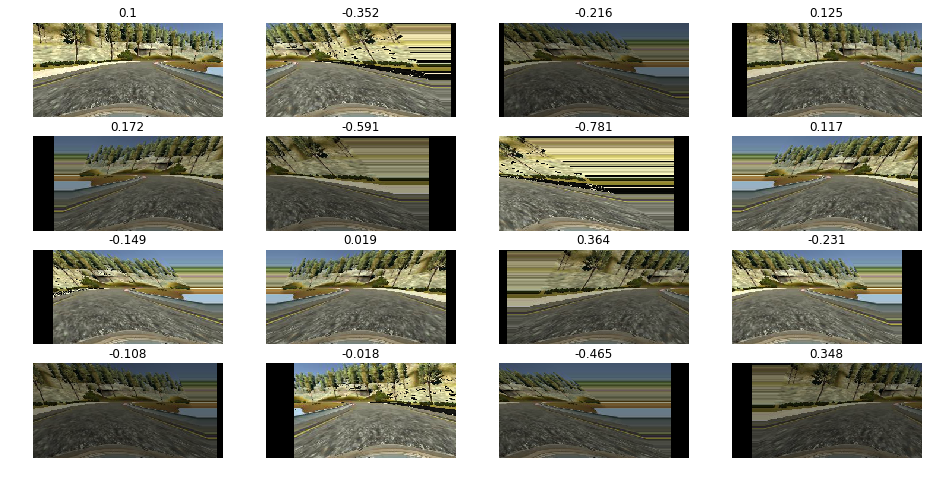

In [78]:
fig, ax = plt.subplots(4,4, figsize=(16,8))

# First image
ax[0,0].imshow(image)
ax[0,0].axis('off')
ax[0,0].set_title(round(angle,3))

for i in range(15):
    new_image, new_angle = random_modif(image, angle)
    d = divmod(i+1,4)
    ax[d[0],d[1]].imshow(new_image)
    ax[d[0],d[1]].axis('off')
    ax[d[0],d[1]].set_title(round(new_angle,3))
    
plt.show()